In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_excel("Online Retail.xlsx")

# Data Preprocessing

In [3]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [30]:
df = df.drop(["Description"],axis=1)

In [31]:
df = df.dropna()

In [32]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

<AxesSubplot:>

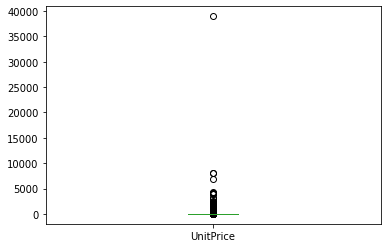

In [33]:
df["UnitPrice"].plot(kind="box")

In [34]:
df_sorted = df[df["Quantity"]!=-1].sort_values(by=["UnitPrice"], ascending=False)

In [35]:
len(df_sorted[df_sorted["UnitPrice"]>1000])

22

In [36]:
df = df_sorted[df_sorted["UnitPrice"]<1000][df_sorted["Quantity"]>0][df["UnitPrice"]>0]

C:\Users\nehue\AppData\Local\Temp\ipykernel_3320\41533685.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_sorted[df_sorted["UnitPrice"]<1000][df_sorted["Quantity"]>0][df["UnitPrice"]>0]


In [37]:
import re

In [38]:
stc = df["StockCode"].unique()

stock_with_words = [stockcode for stockcode in stc if type(stockcode)!=int]
stock_with_words = [sc for sc in stock_with_words if not any(char.isdigit() for char in sc)]

In [39]:
stock_with_words

['DOT', 'M', 'POST', 'BANK CHARGES', 'PADS']

In [40]:
for word in stock_with_words:

    df = df[df["StockCode"]!=word]

<AxesSubplot:>

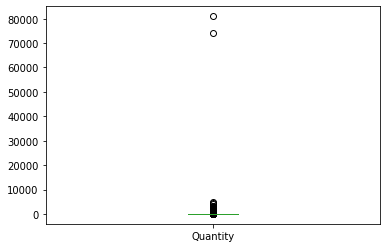

In [41]:
df["Quantity"].plot(kind="box")

In [42]:
df[df["Quantity"]>10000]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
61619,541431,23166,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom


In [43]:
df = df[df["Quantity"]<3000]


# Feature selection and engineering

- Create more features (based on each customer): average_purchase_quantity, average_purchase_expense, Purchase_frequency, Total_cancelled_orders, time_as_buyer, lifetime_expenses, unique_items_bought

- Encode categorical features: Country



In [45]:
# average_purchase_quantity

df['average_purchase_quantity'] = df.groupby('CustomerID')['UnitPrice'].transform('mean')

In [46]:
# average_purchase_expense

df['average_purchase_expense'] = df.groupby('CustomerID')['Quantity'].transform('mean')

In [47]:
# Purchase_frequency

purchase_dates = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max', "count"])

purchase_dates['Purchase_frequency'] = (purchase_dates['max'] - purchase_dates['min']).dt.days / purchase_dates["count"]

df = pd.merge(df, purchase_dates['Purchase_frequency'], on='CustomerID')

In [117]:
# Total_cancelled_orders

cancelled_orders = 0

df["InvoiceNo"] = df["InvoiceNo"].astype(str)

customers = df.groupby("CustomerID")

In [123]:
for i in df["InvoiceNo"].unique():
    if "C" in i or "c" in i:

        print(i)

In [118]:
cancelled_orders = customers.apply(lambda group: group[group['InvoiceNo'].str.contains('C', case=False)])

In [119]:
cancelled_orders

,,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Purchase_expense,average_purchase_quantity,average_purchase_expense,Purchase_frequency
CustomerID,,,,,,,,,,,,


In [49]:
correlation_matrix = df.corr()
print(correlation_matrix)

                           Quantity  UnitPrice  CustomerID  Purchase_expense  \
Quantity                   1.000000  -0.084959   -0.024696          0.495175   
UnitPrice                 -0.084959   1.000000   -0.010902          0.226755   
CustomerID                -0.024696  -0.010902    1.000000         -0.010385   
Purchase_expense           0.495175   0.226755   -0.010385          1.000000   
average_purchase_quantity -0.030489   0.410673   -0.026545          0.290137   
average_purchase_expense   0.650676  -0.019243   -0.037954          0.404558   
Purchase_frequency         0.120243   0.028683   -0.005094          0.074188   

                           average_purchase_quantity  \
Quantity                                   -0.030489   
UnitPrice                                   0.410673   
CustomerID                                 -0.026545   
Purchase_expense                            0.290137   
average_purchase_quantity                   1.000000   
average_purchase_expens

C:\Users\nehue\AppData\Local\Temp\ipykernel_3320\2020863294.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


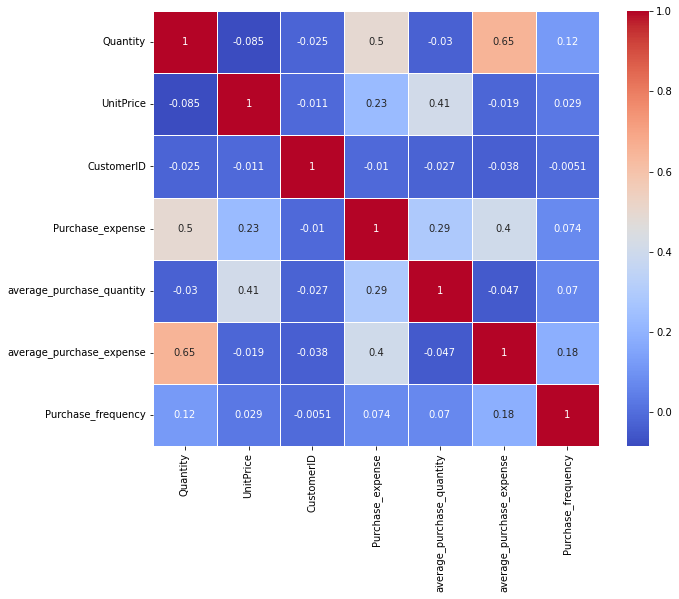

In [50]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [51]:
len(df.StockCode.unique())

3659

In [52]:
df_encoded = pd.get_dummies(df, columns=['Country'])

In [53]:
df_encoded

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Purchase_expense,average_purchase_quantity,average_purchase_expense,Purchase_frequency,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,556444,22502,60,2011-06-10 15:28:00,649.50,15098.0,38970.00,434.650000,40.333333,0.000000,...,0,0,0,0,0,0,0,0,1,0
1,556446,22502,1,2011-06-10 15:33:00,649.50,15098.0,649.50,434.650000,40.333333,0.000000,...,0,0,0,0,0,0,0,0,1,0
2,556442,22502,60,2011-06-10 15:22:00,4.95,15098.0,297.00,434.650000,40.333333,0.000000,...,0,0,0,0,0,0,0,0,1,0
3,543253,22655,1,2011-02-04 15:32:00,295.00,14842.0,295.00,5.326276,8.041379,1.820690,...,0,0,0,0,0,0,0,0,1,0
4,573020,22424,1,2011-10-27 12:37:00,12.75,14842.0,12.75,5.326276,8.041379,1.820690,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396456,568666,17003,720,2011-09-28 12:54:00,0.16,14609.0,115.20,0.143333,1280.000000,74.666667,...,0,0,0,0,0,0,0,0,1,0
396457,544152,18007,2400,2011-02-16 12:10:00,0.06,14609.0,144.00,0.143333,1280.000000,74.666667,...,0,0,0,0,0,0,0,0,1,0
396458,560582,17096,291,2011-07-19 15:30:00,0.17,12875.0,49.47,0.170000,1009.500000,109.500000,...,0,0,0,0,0,0,0,0,1,0
396459,538420,17096,1728,2010-12-12 12:03:00,0.17,12875.0,293.76,0.170000,1009.500000,109.500000,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Leaving out unecessary features:



# Feature scaling

In [54]:
from sklearn.preprocessing import StandardScaler

In [55]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

ValueError: could not convert string to float: '84970S'